In [1]:
from pycocotools.coco import COCO
import numpy as np
import cv2
import os
import json

import matplotlib.pyplot as plt

#### 기존 json 파일 -> 새로운 ann 추가된 json 파일로 변경 및 이미지 생성

- loadImgs( ) 부분은 그대로
- loadAnns( ) 부분은 새로운 ann 추가 (ann 정보 추가 및 ann_id 수정)

약 3분 30초 소요

In [2]:
# 1. coco 데이터셋에서 이미지, 주석 불러오기 

def load_image_and_annotations(coco, img_dir, img_id):
    # image
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    image = cv2.imread(img_path)

    # annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # bbox 추출
    annotations = []
    for ann in anns:
        bbox = ann['bbox']
        xmin, ymin, w, h = bbox
        xmax = xmin + w
        ymax = ymin + h
        label = ann['category_id']
        annotations.append([xmin, ymin, xmax, ymax, label])
    
    annotations = np.array(annotations)
    return {'img':image, 'annot':annotations}

In [3]:
# 2. 각 이미지에 대해 smallobjectaugmentation 적용 후 이미지 저장

def apply_augmentation(coco, img_dir, output_dir, small_object_augmenter, img_id):
    original = load_image_and_annotations(coco, img_dir, img_id)
    augmented = small_object_augmenter(original)
    augmented_image = augmented['img']
    augmented_ann = augmented['annot']

    img_info = coco.loadImgs(img_id)[0]

    os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
    
    augmented_img_path = os.path.join(output_dir, img_info['file_name'])
    cv2.imwrite(augmented_img_path, augmented_image)

    return augmented_ann

In [4]:
# 3. augmented_ann을 coco 형식으로 변환 후 json 파일로 저장

def save_new_annotations(augmented_ann, output_json, img_id, start_ann_id):
    new_annotations = []
    ann_id = start_ann_id

    for ann in augmented_ann:
        xmin, ymin, xmax, ymax, label = ann
        w = xmax - xmin
        h = ymax - ymin
        new_bbox = [xmin, ymin, w, h]

        new_ann = {
            'image_id' : img_id,
            'category_id' : int(label),
            'area' : w*h,
            'bbox' : new_bbox, 
            'iscrowd' : 0,
            'id' : ann_id
        }

        new_annotations.append(new_ann)
        ann_id += 1

    output_json['annotations'].extend(new_annotations)

    return ann_id # 다음 이미지에서 시작할 ann_id 반환

In [5]:
# 4. 
from small_object.small_object_augmentation import SmallObjectAugmentation

def main(json_path, img_dir, output_dir, output_json_path, small_object_augmenter):
    os.makedirs(output_dir, exist_ok=True)
    
    coco = COCO(json_path)
    img_ids = coco.getImgIds()

    output_json = {
        'images': [],
        'annotations': [],
        'categories': []
    }

    start_ann_id = 0
    
    for img_id in img_ids:
        augmented_annotations = apply_augmentation(coco, img_dir, output_dir, small_object_augmenter, img_id)
        start_ann_id = save_new_annotations(augmented_annotations, output_json, img_id, start_ann_id)
    
    # images, categories 정보는 기존 json 파일과 동일
    with open(json_path, 'r') as f:
        original_json = json.load(f)

    output_json['images'] = original_json['images']
    output_json['categories'] = original_json['categories']

    with open(output_json_path, 'w') as f:
        json.dump(output_json, f)

    print(f'Create new json file {output_json_path}')

In [6]:
# json_path = './dataset/train.json'
# img_dir = './dataset/'
json_path = './dataset/train.json'
img_dir = './dataset/'
output_dir = './newdataset/'
output_json_path = './newdataset/train.json'
small_object_augmenter = SmallObjectAugmentation(thresh=100*100, prob=1, epochs=50, seed=20)

main(json_path, img_dir, output_dir, output_json_path, small_object_augmenter)


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
Create new json file ./newdataset/train.json


#### augmentation 적용 후 EDA

In [9]:
# 추가된 annotation 양 확인

with open('./newdataset/train.json') as f:
    data = json.load(f)
with open('./dataset/train.json') as f:
    original = json.load(f)

print(f'augmentation 적용 전 annotation 수 : {len(original["annotations"])}')
print(f'augmentation 적용 후 annotation 수 : {len(data["annotations"])}')

augmentation 적용 전 annotation 수 : 23144
augmentation 적용 후 annotation 수 : 29007


In [22]:
# annotation이 추가된 image_id 찾기

new_ann = []

with open('./newdataset/train.json') as f:
    data = json.load(f)
with open('./dataset/train.json') as f:
    original = json.load(f)

for id in range(len(original['images'])):
    count_ori = sum(ann['image_id']==id for ann in original['annotations'])
    count_data = sum(ann['image_id']==id for ann in data['annotations'])
    if count_ori != count_data:
        new_ann.append([id, count_ori, count_data])

print(new_ann) # [image_id, count_original_ann, count_new_ann]

[[5, 22, 36], [15, 3, 6], [38, 14, 17], [42, 22, 34], [45, 19, 31], [51, 13, 19], [62, 28, 31], [70, 12, 18], [97, 10, 13], [103, 10, 13], [112, 20, 32], [118, 28, 64], [122, 6, 9], [123, 23, 35], [128, 3, 6], [129, 5, 8], [131, 13, 37], [132, 19, 37], [134, 5, 8], [151, 4, 7], [152, 9, 12], [160, 13, 16], [161, 12, 21], [168, 31, 43], [170, 7, 10], [176, 10, 13], [178, 26, 29], [184, 7, 10], [187, 10, 13], [209, 11, 14], [221, 28, 31], [228, 24, 33], [229, 12, 21], [230, 10, 16], [235, 12, 15], [239, 23, 26], [250, 20, 23], [252, 15, 23], [257, 10, 25], [260, 13, 19], [268, 5, 8], [276, 4, 7], [298, 7, 19], [299, 18, 21], [300, 9, 27], [321, 30, 32], [324, 8, 11], [352, 33, 59], [356, 4, 7], [384, 38, 96], [389, 29, 52], [391, 12, 21], [394, 48, 54], [402, 25, 31], [408, 11, 26], [424, 7, 10], [442, 11, 14], [449, 14, 32], [456, 7, 13], [489, 15, 21], [493, 22, 28], [500, 8, 11], [502, 3, 6], [521, 6, 9], [532, 14, 26], [533, 14, 23], [550, 22, 28], [552, 15, 18], [558, 8, 14], [560, 

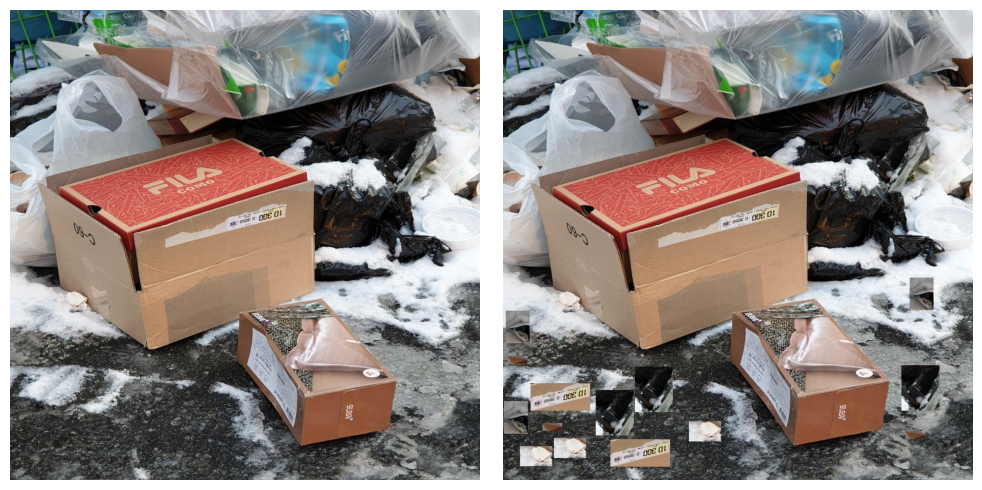

In [25]:
# annotation 추가된 이미지 확인

fig, axes = plt.subplots(1, 2, figsize=(10,5))

image0 = cv2.imread('./dataset/train/0005.jpg')
image0 = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)
image1 = cv2.imread('./newdataset/train/0005.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

axes[0].imshow(image0)
axes[1].imshow(image1)

axes[0].axis('off')
axes[1].axis('off')

plt.tight_layout()
plt.show()

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


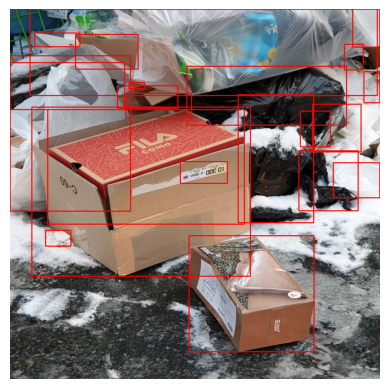

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


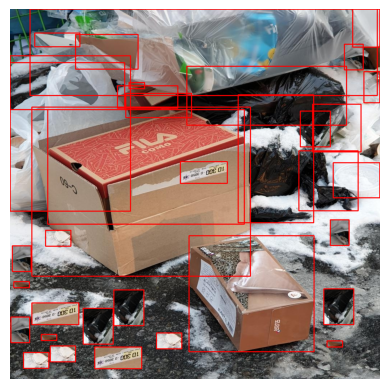

In [31]:
# bbox 추가된 이미지 확인

def draw_bboxes(image_id, json_path, img_dir):
    coco = COCO(json_path)

    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(image_id)
    annotations = coco.loadAnns(ann_ids)

    for ann in annotations:
        xmin, ymin, w, h = ann['bbox']
        xmax = xmin+w
        ymax = ymin+h
        cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

draw_bboxes(5, './dataset/train.json', './dataset/')
draw_bboxes(5, './newdataset/train.json', './newdataset/')


In [67]:
# 특정 area 보다 작은 bbox ann_id, image_id 찾기

def find_small_objects(json_path, w, h):
    with open(json_path, 'r') as f:
        data = json.load(f)

    small_objects = []

    for ann in data['annotations']:
        if ann['area'] < w*h:
            small_objects.append({'image_id':ann['image_id'],
                                  'ann_id': ann['id']})
    return small_objects

print(find_small_objects('./dataset/train.json', 100,100))

[{'image_id': 1, 'ann_id': 7}, {'image_id': 1, 'ann_id': 8}, {'image_id': 4, 'ann_id': 17}, {'image_id': 5, 'ann_id': 21}, {'image_id': 5, 'ann_id': 22}, {'image_id': 5, 'ann_id': 24}, {'image_id': 5, 'ann_id': 29}, {'image_id': 5, 'ann_id': 31}, {'image_id': 5, 'ann_id': 36}, {'image_id': 5, 'ann_id': 38}, {'image_id': 5, 'ann_id': 39}, {'image_id': 8, 'ann_id': 44}, {'image_id': 13, 'ann_id': 65}, {'image_id': 14, 'ann_id': 76}, {'image_id': 15, 'ann_id': 77}, {'image_id': 15, 'ann_id': 79}, {'image_id': 18, 'ann_id': 92}, {'image_id': 19, 'ann_id': 93}, {'image_id': 19, 'ann_id': 99}, {'image_id': 19, 'ann_id': 100}, {'image_id': 19, 'ann_id': 101}, {'image_id': 21, 'ann_id': 113}, {'image_id': 28, 'ann_id': 124}, {'image_id': 29, 'ann_id': 129}, {'image_id': 32, 'ann_id': 137}, {'image_id': 32, 'ann_id': 138}, {'image_id': 32, 'ann_id': 140}, {'image_id': 32, 'ann_id': 141}, {'image_id': 32, 'ann_id': 142}, {'image_id': 32, 'ann_id': 144}, {'image_id': 32, 'ann_id': 146}, {'image_i